### "Towards a computational phenomenology of mental action: modelling meta-awareness and attentional control with deep parametric active inference" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8396119/

<img src="./image-20231012-092223.png" width="" align="" />

In [67]:
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import matplotlib.pyplot as plt

# Recreate Figure 7 using PyMDP

In [63]:
def softmax_dim2(X):                                                            ###converts matrix of log probabilities to matrix of probabilities
  norm = np.sum(np.exp(X)+10**-5,axis=0)
  Y = (np.exp(X)+10**-5)/norm
  return Y

### set the parameters and initialize the agent

In [68]:
T = 100

# true observations (oddball paradigm)
O = np.zeros(T)             
O[int(T/5)] = 1       
O[int(2*T/5)] = 1     
O[int(3*T/5)] = 1     
O[int(4*T/5)] = 1           

# true (hidden) attention states (first half focused, second half distracted)
x2 = np.concatenate((np.zeros(T//2), np.ones(T//2)))

# perception state posterior distributions (standard vs. deviant)
X1bar = np.zeros(T)

# set up the PyMDP probability data structures
num_obs = [2]
num_states = [2]
num_controls = [1]

# obtained from the documentation
A_shapes = [[o_dim] + num_states for o_dim in num_obs]
B_shapes = [[s_dim, s_dim, num_controls[f]] for f, s_dim in enumerate(num_states)]

A1 = utils.obj_array_zeros(A_shapes)
B1 = utils.obj_array_zeros(B_shapes)

A1[0] = np.array([[.75, .25], [.25, .75]])
B1[0][:,:,0] = np.array([[.8, .2], [.2, .8]])

my_agent = Agent(A=A1, B=B1)

# show the non-intuitive structure of the probability arrays
print(A1.shape, A1[0].shape, B1.shape, B1[0].shape)


(1,) (2, 2) (1,) (2, 2, 1)


### do the simulation

In [79]:

for t in range(T):

    # get the current observation and attention state
    observation = [int(O[t])]
    attentionState = x2[t]
    
    # calculate precision and precision weighted likelihood matrix and store it in agent
    gammaA1 = [.5, 2][int(attentionState)] ** -1
    Abar = softmax_dim2(A1[0] ** gammaA1)
    my_agent.A = Abar

    # infer the (level 1) hidden state and record it for the figure
    qs = my_agent.infer_states(observation)
    X1bar[t] = qs[0][0]


### Plot our (PyMDP) version of Figure 7

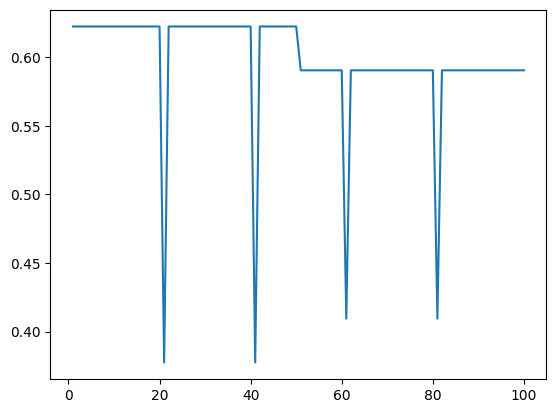

In [80]:
plt.figure()
plt.plot(1 + np.arange(T), X1bar)

# Scratch....

### Example code for PyMDP for reference

In [ ]:
""" Quickly build a random active inference agent, give it an observation and have it do hidden state and policy inference """


num_obs = [3, 5] # observation modality dimensions
num_states = [4, 2, 3] # hidden state factor dimensions
num_controls = [4, 1, 1] # control state factor dimensions
A_array = utils.random_A_matrix(num_obs, num_states) # create sensory likelihood (A matrix)
B_array = utils.random_B_matrix(num_states, num_controls) # create transition likelihood (B matrix)

C_vector = utils.obj_array_uniform(num_obs) # uniform preferences

# instantiate a quick agent using your A, B and C arrays
my_agent = Agent( A = A_array, B = B_array, C = C_vector)

# give the agent a random observation and get the optimized posterior beliefs

observation = [1, 4] # a list specifying the indices of the observation, for each observation modality

qs = my_agent.infer_states(observation) # get posterior over hidden states (a multi-factor belief)

# Do active inference

q_pi, neg_efe = my_agent.infer_policies() # return the policy posterior and return (negative) expected free energies of each policy as well

action = my_agent.sample_action() # sample an action from the posterior over policies